In [56]:
import pickle
import numpy as np
import pandas as pd
import pygeohash as pgh
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import reverse_geocode as rg_cities
from scipy.stats import entropy
import plotly.express as px 
import seaborn as sns
import math

from datetime import datetime
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Detecting Seasonal Patterns in User Movement

There is more to human movement than periodic patterns and social-based movement. While the paper accurately predicts human movement throughout the week, we propose a more all-encompassing analysis that paints a broader picture, exploring monthly and seasonal movement. To do so, we will use the original check-in and friendship datasets from Gowalla and Brightkite and separate them into subsets representing a narrower time of the year. We want to see what mobility patterns are exhibited in different countries and throughout different times of the year: users can go on vacation, travel abroad, and change homes. This would allow us to understand the travelling patterns of users around the world (i.e. who is more likely to travel and where) as well as the distribution of check-ins and their density. We want to produce visualizations showcasing these patterns on a world map. 

Our starting point is the first replication of the Friendship and Mobility paper. We re-use the data-loading and data cleaning part, as well as the technique to determine home locations.

## Loading the data

In [2]:
# The datasets have no headers, so we have to name them for clarity
checkin_header = ['user', 'checkin_time', 'latitude', 'longitude', 'location_id']
edges_header = ['user1', 'user2']

# Load the data by specifying the correct compression algorithm, separator and column names
checkin_brightkite_orig = pd.read_csv('data/loc-brightkite_totalCheckins.txt.gz', compression = 'gzip', sep = '\t', names = checkin_header)
edges_brightkite_orig = pd.read_csv('data/loc-brightkite_edges.txt.gz', compression = 'gzip', sep = '\t', names = edges_header)
checkin_gowalla_orig = pd.read_csv('data/loc-gowalla_totalCheckins.txt.gz', compression = 'gzip', sep = '\t', names = checkin_header)
edges_gowalla_orig = pd.read_csv('data/loc-gowalla_edges.txt.gz', compression = 'gzip', sep = '\t', names = edges_header)

## Cleaning the data

Some of the latitude and longitude values are not in the valid range of [-90, 90] and [-180, 180] respectively. Moreover, the location having (lat, long) = (0,0) is not a valid one. In both datasets, we remove rows in which either of the location attributes are not valid. We also remove the rows of the Brightkite dataset that have NaN values. 

In [3]:
def clean(checkins):
    """ Rids the check-in data of invalid coordinates """
    to_drop = []
    # Select indexes to drop depending on conditions mentionned above 
    to_drop.append(checkins[(checkins['latitude'] < -90.0) | 
                                   (checkins['latitude'] > 90.0)].index)
    to_drop.append(checkins[(checkins['longitude'] < -180.0) | 
                                   (checkins['longitude'] > 180.0)].index)
    to_drop.append(checkins[(checkins['latitude'] == 0) & 
                                   (checkins['longitude'] == 0)].index)
    
    for item in to_drop:
        checkins.drop(item, inplace = True)
    checkins.dropna(inplace = True)
    
    return checkins

In [5]:
# Pass copy of DataFrama in order not to have to reload the original one in case of a mistake
checkin_brightkite = clean(checkin_brightkite_orig.copy())
checkin_gowalla    = clean(checkin_gowalla_orig.copy())

## Adding temporal information to the check-in data

To be able to separate check-ins temporally, we add to each check-in: the day of the week, month, season and year. We also add the hour of the week (a number between 0 and 167). 

In [4]:
def to_datetime(string_date):
    """ Returns the string found in the row to the correctly formatted datetime object """
    return datetime.strptime(string_date, '%Y-%m-%dT%H:%M:%SZ')

def get_season(row):
    """ 
        Returns the season from a certain row
        Adapted from https://stackoverflow.com/a/28688724 
    """
    # Define the datetime intervals according to every season
    Y = 2000 # Leap year to allow input X-02-29, which allows for leap days
    seasons = [('winter', (datetime(Y,  1,  1),  datetime(Y,  3, 20))),
               ('spring', (datetime(Y,  3, 21),  datetime(Y,  6, 20))),
               ('summer', (datetime(Y,  6, 21),  datetime(Y,  9, 22))),
               ('autumn', (datetime(Y,  9, 23),  datetime(Y, 12, 20))),
               ('winter', (datetime(Y, 12, 21),  datetime(Y, 12, 31)))]
    
    date_time = row['checkin_time'].replace(year=Y, hour=0, minute=0, second=0)
    return next(season for season, (start, end) in seasons if start <= date_time <= end)

seasons = ['winter', 'spring', 'summer', 'autumn']
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',\
          7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

In [7]:
# Convert datetime strings to datetime objects
checkin_brightkite['checkin_time'] = checkin_brightkite['checkin_time'].parallel_apply(to_datetime)
checkin_gowalla['checkin_time'] = checkin_gowalla['checkin_time'].parallel_apply(to_datetime)

# Find the month associated with every check-in
checkin_brightkite['month'] = checkin_brightkite.parallel_apply(lambda row: row['checkin_time'].month, axis=1)
checkin_gowalla['month'] = checkin_gowalla.parallel_apply(lambda row: row['checkin_time'].month, axis=1)

# # Find the year associated with every check-in
checkin_brightkite['year'] = checkin_brightkite.parallel_apply(lambda row: row['checkin_time'].year, axis=1)
checkin_gowalla['year'] = checkin_gowalla.parallel_apply(lambda row: row['checkin_time'].year, axis=1)

# Find the season associated with every check-in
checkin_brightkite['season'] = checkin_brightkite.parallel_apply(get_season, axis=1)
checkin_gowalla['season'] = checkin_gowalla.parallel_apply(get_season, axis=1)

# Find the day of week associated with every check-in
checkin_brightkite['day_of_week'] = checkin_brightkite.parallel_apply(lambda row: row['checkin_time'].weekday(), axis=1)
checkin_gowalla['day_of_week'] = checkin_gowalla.parallel_apply(lambda row: row['checkin_time'].weekday(), axis=1)

# Find the hour of week assoiated with every check-in (used for entropy) 
checkin_brightkite['hour_of_week'] = checkin_brightkite.parallel_apply(lambda row: row['day_of_week']*24 + row['checkin_time'].hour, axis=1)
checkin_gowalla['hour_of_week'] = checkin_gowalla.parallel_apply(lambda row: row['day_of_week']*24 + row['checkin_time'].hour, axis=1)

checkin_brightkite.head()

,user,checkin_time,latitude,longitude,location_id,cc,geohash,month,season,day_of_week,hour_of_week,is_abroad,distance_from_home,geohash_precision5,year
0,0,2010-10-17 01:48:53,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,US,9xj6,10,autumn,6,145,False,4.006078,9xj64,2010
1,0,2010-10-16 06:02:04,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,US,9xj6,10,autumn,5,126,False,13.701001,9xj6c,2010
2,0,2010-10-16 03:48:54,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,US,9xj6,10,autumn,5,123,False,13.577496,9xj6c,2010
3,0,2010-10-14 18:25:51,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,US,9xj6,10,autumn,3,90,False,3.730570,9xj64,2010
4,0,2010-10-14 00:21:47,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,US,9xj6,10,autumn,3,72,False,3.455918,9xj64,2010


## Analyzing the data's temporal distribution

As we plan on analyzing the temporal distribution of check-ins and on finding monthly or seasonal patterns, the data needs to be consistent across the time period we want to study. To visualize this, we plot the distribution of the number of checkins as a function of the month and the year. 

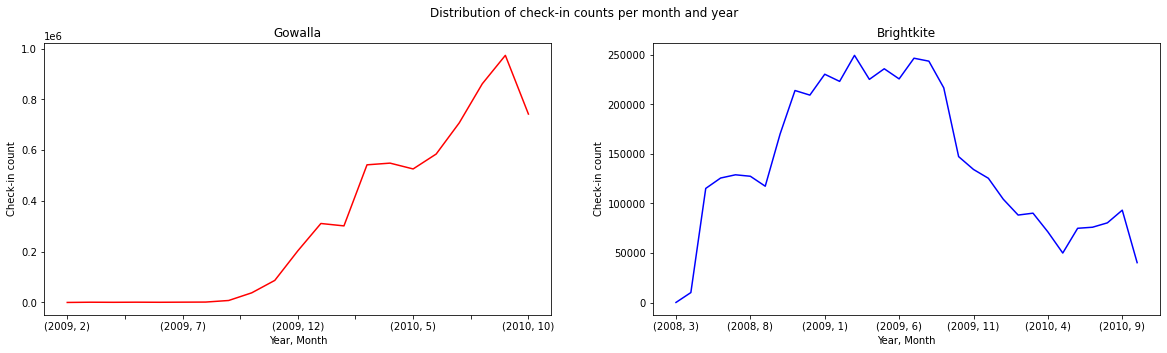

In [42]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))

# Plot the check-in counts per month and year for both data sets
checkin_gowalla.groupby(['year', 'month']).count()['user'].plot(ax = axs[0], title = 'Gowalla', color = 'red')
checkin_brightkite.groupby(['year', 'month']).count()['user'].plot(ax = axs[1], title = 'Brightkite', color = 'blue')

for ax in axs:
    ax.set_xlabel('Year, Month')
    ax.set_ylabel('Check-in count')
plt.suptitle('Distribution of check-in counts per month and year')
plt.show()

We notice that for the Gowalla dataset, there is no consistency across monthly check-in growth: the monthly number of check-ins keeps growing and never stabilizes. This will pose a problem while analyzing check-in patterns for different months. Indeed, this might result in unbalanced and skewed results. Therefore, we decided to drop this dataset for the rest of the study. Later in this notebook, we applied one of our analyses on the Gowalla dataset to show this lack of coherence.

As for the Brightkite dataset, the check-ins are more consistent on a monthly basis, except at the two ends of the available timeline. In order to avoid some months being weighted more than others, we keep check-ins spanning two calendar years, from May 1st 2008 until April 30th 2010. The plots below shows that the distribution is more balanced over that filtered timeline: we avoid months with a check-in count close to zero. More specifically, we avoid some months having less or more check-ins than others.

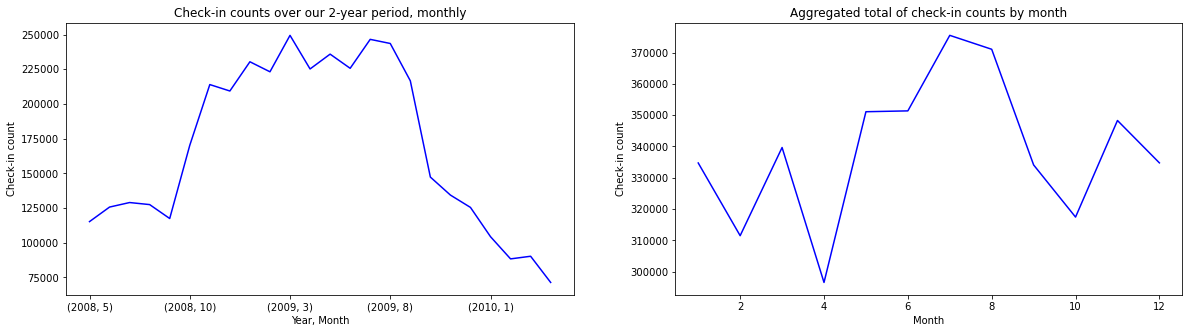

In [43]:
# Keep a subset of the check-ins for the period mentioned above
bright_kite_test = checkin_brightkite[(checkin_brightkite['checkin_time'] >= datetime(2008, 5, 1, 0, 0, 0)) & (checkin_brightkite['checkin_time'] < datetime(2010, 5, 1, 0, 0, 0))]

fig, axs = plt.subplots(1, 2, figsize = (20, 5))

# Plot the distributions
bright_kite_test.groupby(['year','month']).count()['user'].plot(ax = axs[0], xlabel = 'Year, Month', ylabel = 'Check-in count', color = 'blue')
bright_kite_test.groupby(['month']).count()['user'].plot(ax = axs[1], xlabel = 'Month', ylabel = 'Check-in count', color = 'blue')

# Plot attributes
axs[0].title.set_text("Check-in counts over our 2-year period, monthly")
axs[1].title.set_text("Aggregated total of check-in counts by month")
plt.show()

In [47]:
# Keep the check-ins over the two year period
checkin_brightkite = bright_kite_test

## Adding country information to check-ins

For each check-in, we append the country code corresponding to the country the check-in was made in. This is done using a reverse geohashing library [`reverse_geocoder`](https://github.com/thampiman/reverse-geocoder) that maps coordinates (latitutde, longitude) to information about a specific place (e.g. city, country, country code).

In [53]:
def extract_coordinates(row):
    return (row['latitude'], row['longitude'])

def coordinates_to_country(df):
    """
        Maps the coordinates of a dataframe to the country
        code using reverse geocoding
    """
    coordinates_tuples = list(df.parallel_apply(extract_coordinates, axis = 1))
    geocodes = rg.search(coordinates_tuples)
    return [gc['cc'] for gc in geocodes]

In [ ]:
# Append country codes to each check-in for both datasets
checkin_brightkite['cc'] = coordinates_to_country(checkin_brightkite)

checkin_brightkite.head()

## Determining the location of user homes

Here, the geohash is used to determine the home location for every user. Since this is similar to what was done in the replication, we will not go into detail about the implementation and justification.

In [5]:
def geohash_encode(row, precision = 4):
    """
        Computes and returns the geohash with 
        precision 4 for a given row 
    """
    return pgh.encode(*extract_coordinates(row), precision=precision)

def find_home(checkins, user_id):
    """
        Given a user id, finds the most common world cell and 
        computes average location to estimate home location
    """
    # Retrieve all the user's check-ins
    group = checkins[checkins['user']  == user_id]
    # Get the most common geohash for the user
    geohash = group.groupby('geohash').size().idxmax()
    
    # Keep all checkins that happened in the most common geohash and compute average position
    return group[group['geohash'] == geohash][['latitude', 'longitude']].mean()

In [9]:
# Compute the geohash for each check-in entry: that will determine the cell in which each check-in belongs
checkin_brightkite['geohash'] = checkin_brightkite.parallel_apply(geohash_encode, axis = 1)

In [11]:
# All the users that made at least 1 check-in
brightkite_users = set(checkin_brightkite.user)

# Create empty DataFrame with user ids and apply function to all users
brightkite_homes = pd.DataFrame(index = brightkite_users).index.to_series().parallel_apply(lambda user_id: find_home(checkin_brightkite, user_id)) 

# Add the country codes to the homes
brightkite_homes['cc'] = coordinates_to_country(brightkite_homes)

brightkite_homes.head()

,latitude,longitude,cc
0,39.783678,-104.992871,US
1,37.643427,-122.416294,US
2,39.777215,-105.003989,US
3,37.765367,-122.424540,US
4,60.174029,24.937171,FI


In [12]:
# Store homes in dictionary for faster access
brightkite_homes = brightkite_homes.to_dict(orient = 'index')

## Identify travelers

We now indentify users who travel. We define a traveler as a user who has made at least one check-in outside of his home country (determined by the country of its home location). From this definition, we mark each check-in depending on whether it was made while abroad or not. 

In [6]:
def travel_check(row, homes):
    """ 
        A check-in corresponds to a travel if it was made in a country 
        different than the user's home country
    """
    return row['cc'] != homes[row['user']]['cc']

In [9]:
# Determine whether each check-in corresponds to a check-in made while abroad
checkin_brightkite['is_abroad'] = checkin_brightkite.parallel_apply(lambda row: travel_check(row, brightkite_homes), axis = 1)
checkin_gowalla['is_abroad'] = checkin_gowalla.parallel_apply(lambda row: travel_check(row, gowalla_homes), axis = 1) # to show that gowalla can't be used

## When are users more likely to travel ?

During certain periods, it is natural that people break their weakly movenent pattern: whether it is for a vacation or a work trip, users will check-in far from their home. We are interested in understanding these traveling patterns. This entails finding the time of the year users are more likely to check-in at a location abroad (in a country different from their home country) or travel far from home. 

Naturally, users that made check-ins outside of their home country will tend to travel further. For each season, we plot the distribution of home distances for both datasets and separate check-ins made while abroad from the rest. 

In [8]:
# Credits of the function implementation: https://stackoverflow.com/a/15737218
from math import radians, cos, sin, asin, sqrt
def haversine(lat1, lon1, lat2, lon2):
    """
        Calculates the great circle distance (in km) between two points 
        on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [7]:
def get_distance_from_home(row, homes):
    """ 
    calulate_home_distance_bk: calulates the distance between two lat/long coordinaes, which
                               in this case are the homes of two friends using the coordinates
                               in the bk_user_homes dataframe
    arg row: a row from the dataframe containingn friend data
    """  
    home_lat = homes[row['user']]['latitude']
    home_long = homes[row['user']]['longitude']

    return haversine(home_lat, home_long, row['latitude'], row['longitude'])

In [24]:
# Compute the distance between each check-in and the home of the user that made it 
checkin_brightkite['distance_from_home'] = checkin_brightkite.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)

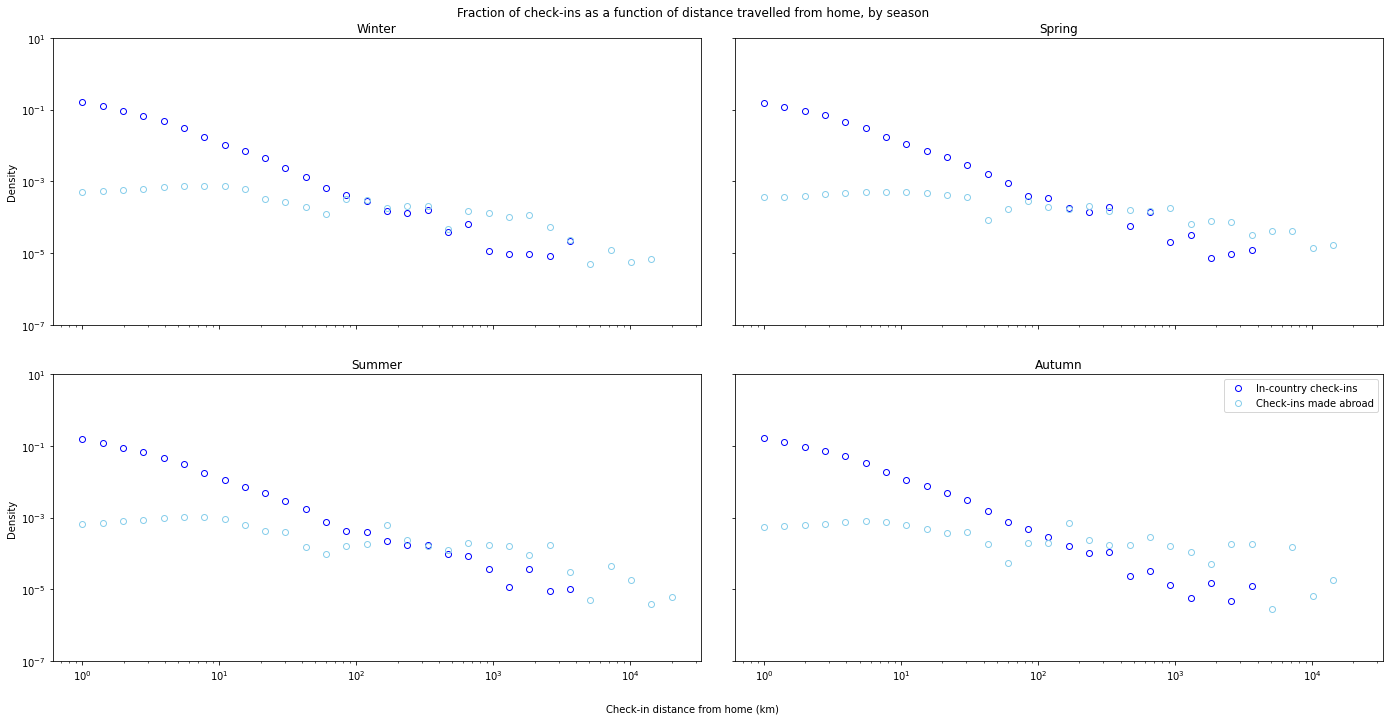

In [48]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10), sharex = True, sharey = True)
axs = axs.ravel()

# Store the max distance, for KDE evaluation logspace
max_dist = math.log10(checkin_brightkite.distance_from_home.max())

for i, season in enumerate(seasons):
    # For each season, plot the distribution of check-in distances from home for check-ins made abroad and in-country 
    checkin_brightkite[(~checkin_brightkite['is_abroad']) & (checkin_brightkite['season'] == season)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 30), loglog=True, 
                                                                 ls = '', marker = 'o', fillstyle = 'none', color = 'blue', ax = axs[i])
    checkin_brightkite[(checkin_brightkite['is_abroad']) & (checkin_brightkite['season'] == season)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 30), loglog=True, 
                                                                 ls = '', marker = 'o', fillstyle = 'none', color = 'skyblue', ax = axs[i])
    
    axs[i].title.set_text(season.capitalize())

# Plot attributes
fig.tight_layout(pad = 3)
fig.text(0.5, 0, 'Check-in distance from home (km)', ha='center')
plt.ylim(10e-8, 10e0)
plt.legend(['In-country check-ins', 'Check-ins made abroad'])
plt.suptitle('Fraction of check-ins as a function of distance travelled from home, by season')
plt.show()

The trend for each season is very similar. We do not see any particular increase in the probability of traveling further depending on the season. 
- Notice that, for in-country check-ins (solid color), the probability of checking-in far from home is high at a close distance, and decreases the further the check-in is. 
- For check-ins made abroad (pastel color), the probability of checking-in close to home is low, but stays rather constant for a long ditance (with a slight decrease towards 1000km).

We plot the frequency of check-ins made abroad for each month, to try and find periods during which people travel more. This will tell us if there are popular months among travelers (i.e summer months). 

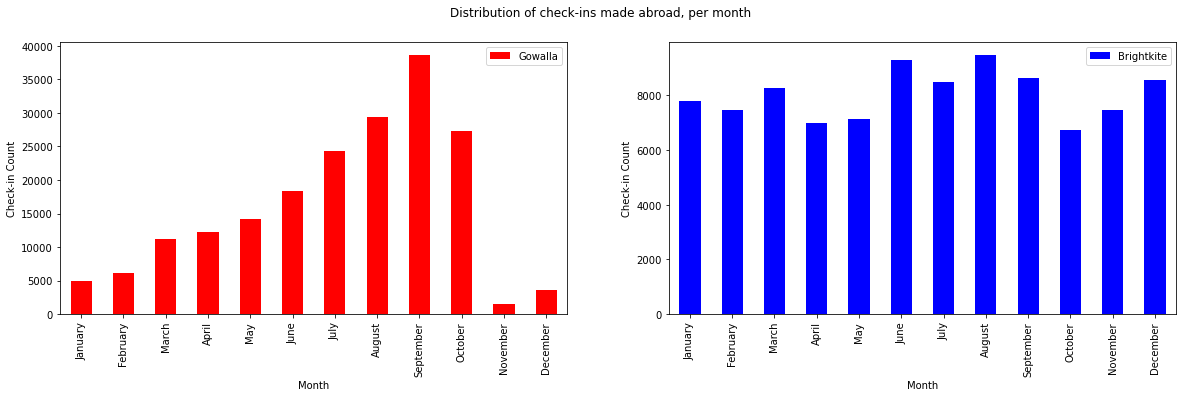

In [59]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharex = True)
axs = axs.ravel()

# Plot the frequency of check-ins made abroad for each month
checkin_gowalla[checkin_gowalla['is_abroad']].groupby('month')['user'].count().plot.bar(color = 'red', ax = axs[0])
checkin_brightkite[checkin_brightkite['is_abroad']].groupby('month')['user'].count().plot.bar(color = 'blue', ax = axs[1])

for ax in axs:
    ax.set_xlabel('Month')
    ax.set_ylabel('Check-in Count')
    ax.set_xticks(range(0, 12))
    ax.set_xticklabels(months.values())
    ax.tick_params('x', rotation = 90)

axs[0].legend(['Gowalla'])
axs[1].legend(['Brightkite'])
plt.suptitle('Distribution of check-ins made abroad, per month')
plt.show()

We see a spike in the frequency of check-ins abroad in June, July, September and August, i.e. summer months. This means that users tend to travel more during summer, even though some smill travel during the rest of the year. 

> Notice that the Gowalla plot shows a monthly grows of check-in counts, which is not stable enough to carry out our analysis. As stated previously, we will drop that dataset from now on. 

### Analyzing monthly and seasonal entropy

We will now compute the entropy of check-in locations for each month and season. In order to do so, we need a way to represent neighboring locations as one single entity: we will reuse geohashes, but this time with a larger precision. Even though this does not indicate whether users travel abroad, it still shows the variability of their movement throughout the year. To compute the entropy, we use `scipy.stat`'s entropy method that takes as input value counts. 

In [76]:
# Compute geohash of all check-ins with larger precision
checkin_brightkite['geohash_precision5'] = checkin_brightkite.parallel_apply(lambda row: geohash_encode(row, precision=5), axis = 1)

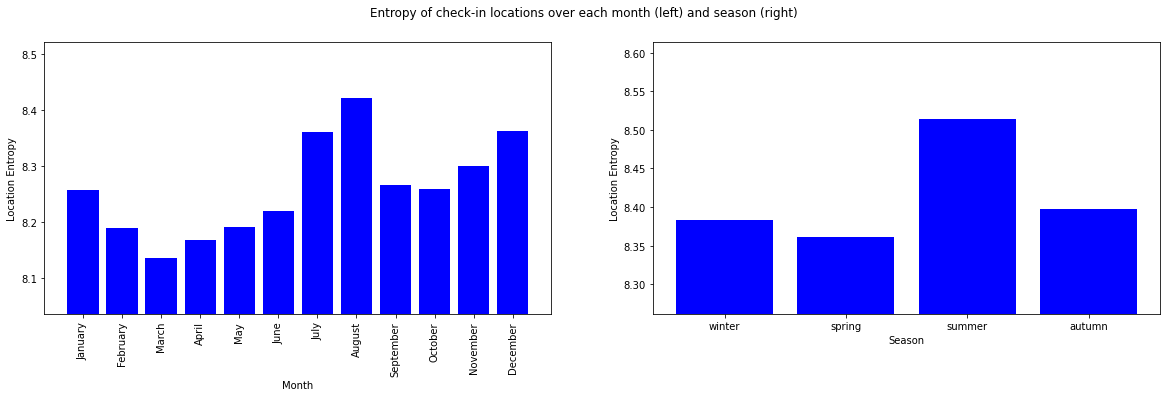

In [75]:
brightkite_monthly_entropies = []
brightkite_seasonal_entropies = []

for i in range(12):
    # Compute the entropy of the check-in locations using geohashes over each month
    series = pd.Series(checkin_brightkite[checkin_brightkite['month'] == i+1].geohash_precision5)
    brightkite_monthly_entropies.append(entropy(series.value_counts()))

for season in seasons:
    # Compute the entropy of the check-in locations using geohashes over each season
    series = pd.Series(checkin_brightkite[checkin_brightkite['season'] == season].geohash_precision5)
    brightkite_seasonal_entropies.append(entropy(series.value_counts()))


# Plot the entropies over each month 
fig, axs = plt.subplots(1, 2, figsize = (20, 5))

axs[0].bar(x = list(range(0, 12)), height = brightkite_monthly_entropies, color = 'blue')
axs[1].bar(x = seasons, height = brightkite_seasonal_entropies, color = 'blue')

# Plot properties 
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Location Entropy')
axs[0].set_xticks(range(0, 12))
axs[0].set_xticklabels(months.values())
axs[0].tick_params('x', rotation = 90)
axs[0].set_ylim(min(brightkite_monthly_entropies) - 0.1, max(brightkite_monthly_entropies) + 0.1)

axs[1].set_xlabel('Season')
axs[1].set_ylabel('Location Entropy')
axs[1].set_ylim(min(brightkite_seasonal_entropies) - 0.1, max(brightkite_seasonal_entropies) + 0.1)

plt.suptitle('Entropy of check-in locations over each month (left) and season (right)')
plt.show()

We observe that the entropy is higher during the summer (and the summer months). This shows that the variability of check-ins is higher during that time period and hints at higher non-periodic user movement in summer. That change certainly due to the fact that people tend to go out and take vacations when it's warmer.

### Analyzing weekly entropy on a monthly/seasonal basis

After analyzing the entropy of locations over a whole period of time, we will now analyze the same metric on a weekly basis (for each hour of the week), and plot it for every period of time (i.e. seasons or months).

In [76]:
brightkite_monthly_entropies = []
brightkite_seasonal_entropies = []

for m in range(0, 12): # Repeat the computation for each month
    entropies_brightkite = []
    for i in range(168):
        # For each hour of the week, compute the entropy of the week's hour for the given month
        entropies_brightkite.append(entropy(checkin_brightkite[(checkin_brightkite['hour_of_week'] == i) & (checkin_brightkite['month'] == m+1)]\
                                 .geohash_precision5.value_counts(), base = 2))
    brightkite_monthly_entropies.append(entropies_brightkite)    
    

for s in seasons: # Repeat the computation for each season
    entropies_brightkite = []
    for i in range(168): 
        # For each hour of the week, compute the entropy of the week's hour for the given season
        entropies_brightkite.append(entropy(checkin_brightkite[(checkin_brightkite['season'] == s) & (checkin_brightkite['hour_of_week'] == i)]\
                                 .geohash_precision5.value_counts(), base = 2))                                 
    brightkite_seasonal_entropies.append(entropies_brightkite)    

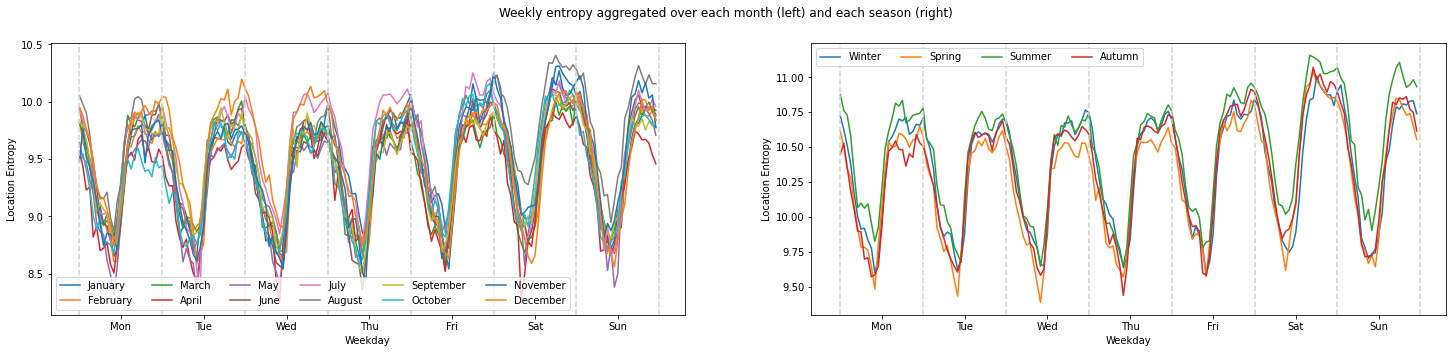

In [88]:
fig, axs = plt.subplots(1, 2, figsize = (25, 5), sharex = True)

# Plot the entropies for each hour of the week, for each month
for i in range(0,12):
    axs[0].plot(list(range(168)), brightkite_monthly_entropies[i])  
# Now for each season
for i in range(0,4):
    axs[1].plot(list(range(168)), brightkite_seasonal_entropies[i]) 
    
# Plot vertical lines to show the seperation between days of the week
for i in range(0, 169, 24):
    axs[0].axvline(i, color = 'lightgrey', ls = '--')
    axs[1].axvline(i, color = 'lightgrey', ls = '--')

# Plot properties 
for ax in axs:
    ax.set_xlabel('Weekday')
    ax.set_ylabel('Location Entropy')
    ax.set_xticks([24*i + 12 for i in range(7)])
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    
axs[0].legend(months.values(), ncol = 6)
axs[1].legend([s.capitalize() for s in seasons], ncol = 4)

plt.suptitle('Weekly entropy aggregated over each month (left) and each season (right)')
plt.show()

We notice that the location entopy during the week-ends is always higher, as it was pointed out by the authors of the original paper. This trend is further accentuated during the summer, as seen on the right-hand plot. This means that the people's movement patterns vary more and are less predictable. For other seasons, notably the spring and autumn, people seem to be more set in their routines, hence the slightly lower entropy. 

## Pickle the data

In [ ]:
# pickle.dump(checkin_brightkite, open('pickles/checkin_brightkite', 'wb'))
# pickle.dump(checkin_gowalla, open('pickles/checkin_gowalla', 'wb'))

# pickle.dump(brightkite_homes, open('pickles/brightkite_homes', 'wb'))
# pickle.dump(gowalla_homes, open('pickles/gowalla_homes', 'wb'))

In [4]:
checkin_brightkite = pickle.load(open('pickles/checkin_brightkite', 'rb'))
checkin_gowalla = pickle.load(open('pickles/checkin_gowalla', 'rb'))

In [5]:
brightkite_homes = pickle.load(open('pickles/brightkite_homes', 'rb'))
gowalla_homes = pickle.load(open('pickles/gowalla_homes', 'rb'))

## How does the home location change temporally

During summer, holidays or even weekends, it is common for people to live in another place for a few weeks, e.g in a summer house or mountain cottage. We would now like to study what is the proportion of users that change homes throughout the year, and check if these home changes correspond to a special period of the year. We will carry out this analyzis mainly by computing user homes for each period of the year (months and seasons).

To start, we only consider check-ins that were not made abroad, i.e. check-ins that were made in the main home location of the user that made them. We do this to avoid the following scenario. A user from the US is on vacation in Thailand in July, and does some check-ins there: this means we will assign the user a home in Thailand, which is not accurate. 

In [89]:
# Keep check-ins that were not made abroad
brightkite_incountry = checkin_brightkite[~checkin_brightkite['is_abroad']] 

# Print statistics on the numeber of check-ins per user
brightkite_checkins_per_user = {user: len(checkins) for user, checkins in brightkite_incountry.groupby('user')}
pd.Series(brightkite_checkins_per_user).describe()

count    49352.000000
mean        80.437429
std        229.411590
min          1.000000
25%          3.000000
50%         10.000000
75%         48.000000
max       2100.000000
dtype: float64

Notice that 50% of users have made 10 check-ins or less, which is not enough to determine a monthly home location. Moreover, 75% of the users have made 48 check-ins or less. To have pertinent results, we decide to keep the check-ins of users that made 10 check-ins or more: these users are called active users.

In [91]:
# Keep users who made at least 10 check-ins (active users)
brightkite_active_users = [user for user, n_checkins in brightkite_checkins_per_user.items() if n_checkins >= 10 ]

# Keep the check-ins of active users only
brightkite_incountry = brightkite_incountry[brightkite_incountry['user'].isin(brightkite_active_users)]

Once the check-ins have been filtered, we can proceed to find the home location of users for each period. We store the check-ins and results in dictionary with the months/seasons as keys. 

To compute the home locations, we use the same technique as above, but:
- We consider the set of users that made a check-in during the period of interest, 
- We base the calculation on the check-ins made during the period of interest. 

Note that some users might not have made check-ins during every period of interest: we therefore set the home location of such users for that period as their main (yearly) home location.  

In [99]:
# Dictionary: month/season -> DataFrame of check-ins made during that month/season
brightkite_monthly = { month: checkins for month, checkins in brightkite_incountry.groupby('month') }
brightkite_season = { season: checkins for season, checkins in brightkite_incountry.groupby('season') }

# Dictionary: month/season -> DataFrame of home locations during that month/season
brightkite_homes_monthly = {}
brightkite_homes_season = {}

for month, checkins in brightkite_monthly.items():
    # Users that made a check-in during the period
    users = checkins.user.unique()
    
    # Find the homes of the users, based on the check-ins made during that month 
    result = pd.DataFrame(index = users).index.to_series().parallel_apply(lambda user_id: find_home(checkins, user_id))
    result = result.reset_index().rename(columns={'index':'user'})
    
    # Add country location
    result['cc'] = coordinates_to_country(result)
    # Compute the distance from users' main home location
    result['dist_from_yearly_home'] = result.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)

    # Determine users that didn't made a check-in during that period: retrieve their home location
    missing = pd.DataFrame.from_dict(brightkite_homes, orient = 'index', columns = ['latitude', 'longitude', 'cc']).reset_index().rename({'index': 'user'}, axis = 1)
    missing = missing[~missing['user'].isin(checkins.user.unique())]
    # Distance is zero since home location didn't change
    missing['dist_from_yearly_home'] = 0
    
    # Append missing users to result
    result = result.append(missing, ignore_index=True)
    brightkite_homes_monthly[month] = result
    
    print("Done for month", month) # TODO: remove
    
    
# Repeat the process for each season
for season, checkins in brightkite_season.items():
    users = checkins.user.unique()    
    result = pd.DataFrame(index = users).index.to_series().parallel_apply(lambda user_id: find_home(checkins, user_id))
    result = result.reset_index().rename(columns={'index':'user'})
    result['cc'] = coordinates_to_country(result)
    result['dist_from_yearly_home'] = result.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)

    missing = pd.DataFrame.from_dict(brightkite_homes, orient = 'index', columns = ['latitude', 'longitude', 'cc']).reset_index().rename({'index': 'user'}, axis = 1)
    missing = missing[~missing['user'].isin(checkins.user.unique())]
    missing['dist_from_yearly_home'] = 0
    
    result = result.append(missing, ignore_index=True)
    brightkite_homes_season[season] = result
    
    print("Done for season", season) # TODO: remove

Loading formatted geocoded file...
Done for month 1
Done for month 2
Done for month 3
Done for month 4
Done for month 5
Done for month 6
Done for month 7
Done for month 8
Done for month 9
Done for month 10
Done for month 11
Done for month 12
Done for season autumn
Done for season spring
Done for season summer
Done for season winter


To visualize when does the home location of users change, we decided to:
1. Plot the average distance from the users' main (yearly) home
2. Compute and plot the percentage of users that change homes for each period. 

We say that a user changed homes if the distance from his yearly home is greater than 100km apart. We chose 100km as a threshold because, according to the paper, people live in cities that are separated by that distance or more.

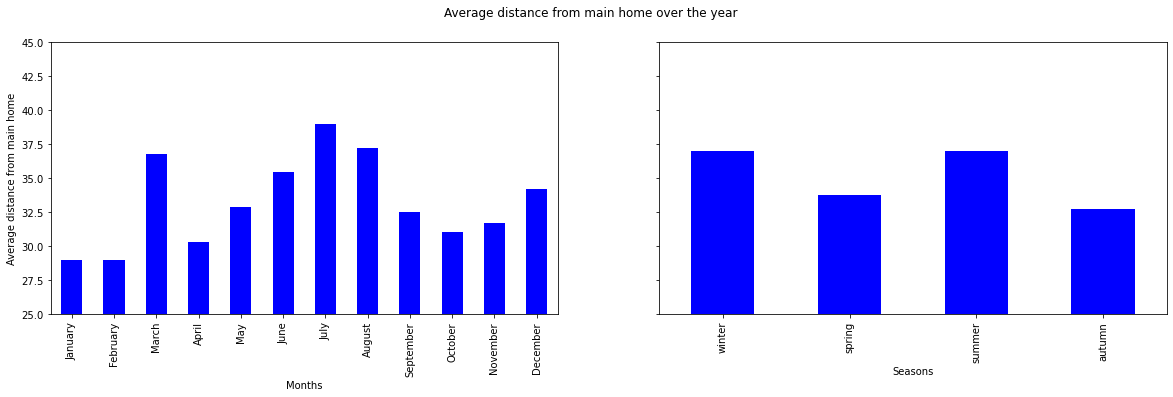

In [102]:
# Collect the distances from yearly home for each month and season
brightkite_monthly_distances = {month: homes.dist_from_yearly_home.mean() for month, homes in brightkite_homes_monthly.items()}
brightkite_season_distances = {season: brightkite_homes_season[season].dist_from_yearly_home.mean() for season in seasons}

fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey = True)
axs = axs.ravel()

# Plot distances from the main home for each period
pd.Series(brightkite_monthly_distances).plot.bar(ax = axs[0], color = 'blue')
pd.Series(brightkite_season_distances).plot.bar(ax = axs[1], color = 'blue')

# Plot attributes
axs[0].set_xlabel('Months')
axs[0].set_xticks(range(0, 12))
axs[0].set_xticklabels(months.values())
axs[1].set_xlabel('Seasons')
axs[0].set_ylabel('Average distance from main home')
plt.ylim(25, 45)

plt.suptitle('Average distance from main home over the year')
plt.show()

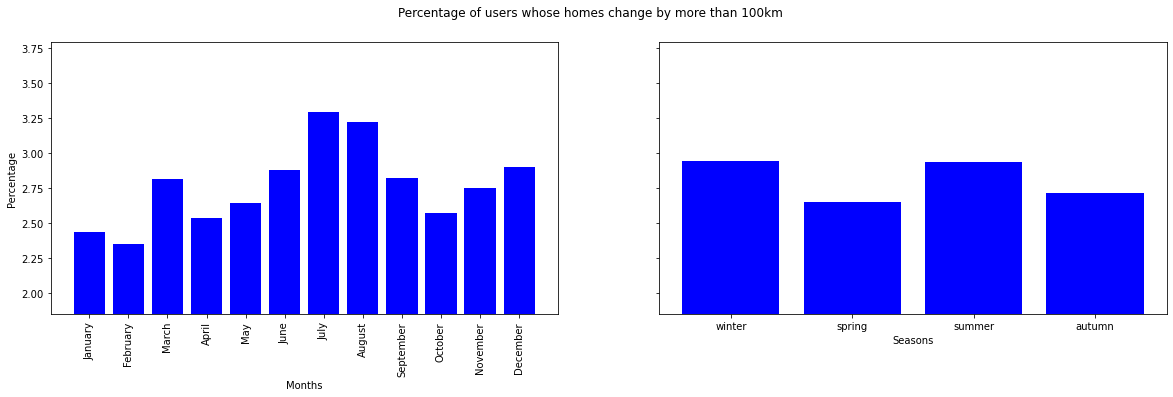

In [108]:
threshold = 100 # People live in cities more than 100km apart
brightkite_monthly_percentages = []
brightkite_season_percentages = []

# Compute the percentage of people who have a new home further than the treshold
for month in range(1, 13):
    distances = brightkite_homes_monthly[month].dist_from_yearly_home
    brightkite_monthly_percentages.append(100*len(distances[distances > threshold])/len(distances))

for season in seasons:
    distances = brightkite_homes_season[season].dist_from_yearly_home
    brightkite_season_percentages.append(100*len(distances[distances > threshold])/len(distances))
        
fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey = True)
axs = axs.ravel()
    
# Plot percentages for each time period
axs[0].bar(x = range(0, 12), height=brightkite_monthly_percentages, color = 'blue')
axs[1].bar(x = seasons, height=brightkite_season_percentages, color = 'blue')

# Plot attributes
axs[0].set_xlabel('Months')
axs[0].set_ylabel('Percentage')
axs[0].set_xticks(range(0, 12))
axs[0].set_xticklabels(months.values())
axs[0].tick_params(axis='x', rotation= 90)
axs[1].set_xlabel('Seasons')
plt.ylim(min(brightkite_monthly_percentages) - 0.5, max(brightkite_monthly_percentages) + 0.5)

plt.suptitle('Percentage of users whose homes change by more than {}km'.format(threshold))
plt.show()

In [5]:
checkin_brightkite = pickle.load(open('pickles/checkin_brightkite', 'rb'))
brightkite_homes = pickle.load(open('pickles/brightkite_homes', 'rb'))

## Analyzing travel destinations

In this part, we look into check-ins that were made while the user was abroad, i.e. those that correspond to travels. 

### Who travels where ?

We first study the distribution of travel check-ins as a function of the destination and the user's nationality globally. A user's nationality is simply the country of her primary home. For visualization purposes, we only carry out the analysis on the 25 most frequent destinations and nationalities. 

In [58]:
# Determine users nationality 
checkin_brightkite['user_nationality'] = checkin_brightkite['user'].parallel_apply(lambda user: brightkite_homes[user]['cc'])

In [59]:
# Isolate check-ins made while travelling
checkin_brightkite_abroad = checkin_brightkite[checkin_brightkite['is_abroad']]

# Find the top countries  
brightkite_top_countries = checkin_brightkite_abroad.groupby('cc').count()['user'].sort_values(ascending=False)
brightkite_top_countries = list(brightkite_top_countries[:25].index)

# Find the top nationalities
brightkite_top_nationalities = checkin_brightkite_abroad.groupby('user_nationality').count()['user'].sort_values(ascending=False)
brightkite_top_nationalities = list(brightkite_top_nationalities[:25].index)

# Keep check-ins made in top countries by top nationalities
checkin_brightkite_abroad = checkin_brightkite_abroad[checkin_brightkite_abroad['cc'].isin(brightkite_top_countries)
                                                     & checkin_brightkite_abroad['user_nationality'].isin(brightkite_top_nationalities)]

Because the Brightkite dataset is dominated by users living in the US, there is naturally more travelers from there: this observation puts more focus on their check-ins to the detriment of the check-ins in other countries and from other nationalities. To account for this, we clamp the colormap's max value to half the count of the maximum travel check-ins in the US: this better displays travel involving other nationalities and destination countries.

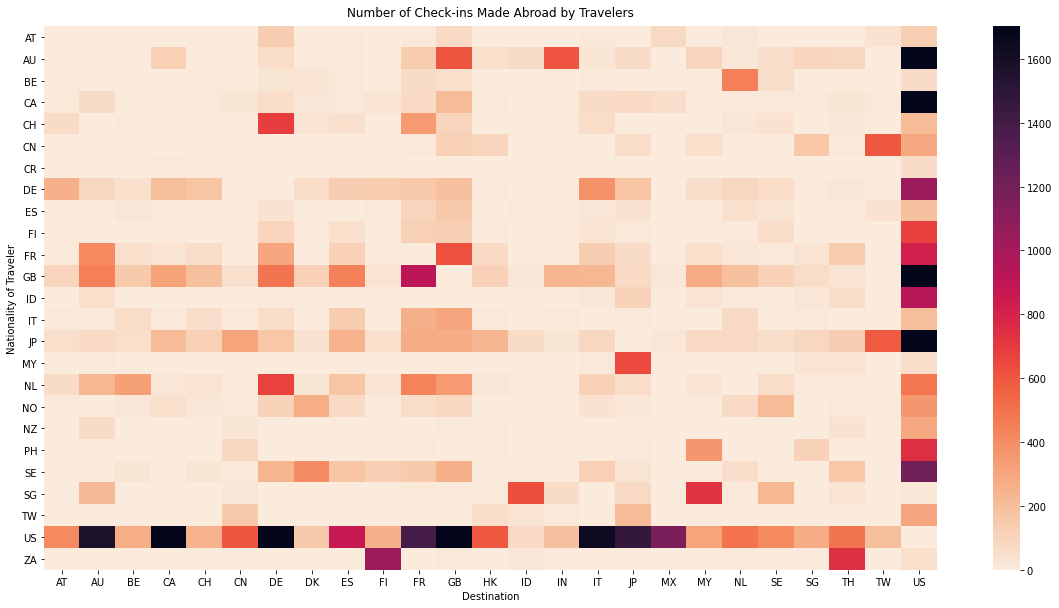

In [60]:
# Compute the frequency of check-ins as a function of nationalities and destination countries 
bk_heatmap_data = pd.crosstab(checkin_brightkite_abroad['user_nationality'],checkin_brightkite_abroad['cc'])

plt.figure(figsize = (20, 10))

# Plot the frequencies on a heatmap
sns.heatmap(bk_heatmap_data, cmap="rocket_r", vmax=max(bk_heatmap_data.US)/2)

# Plot attributes
plt.xlabel('Destination')
plt.ylabel('Nationality of Traveler')
plt.yticks(rotation = 0)
plt.title('Number of Check-ins Made Abroad by Travelers', pad = 10)
plt.show()

Then, we reproduce the same plot for each season, using the same top countries and nationalities. We clamp the colormap's values to a quarter of the max value in the above plot: this is done in order to correctly be able to compare travel trends across seasons. 

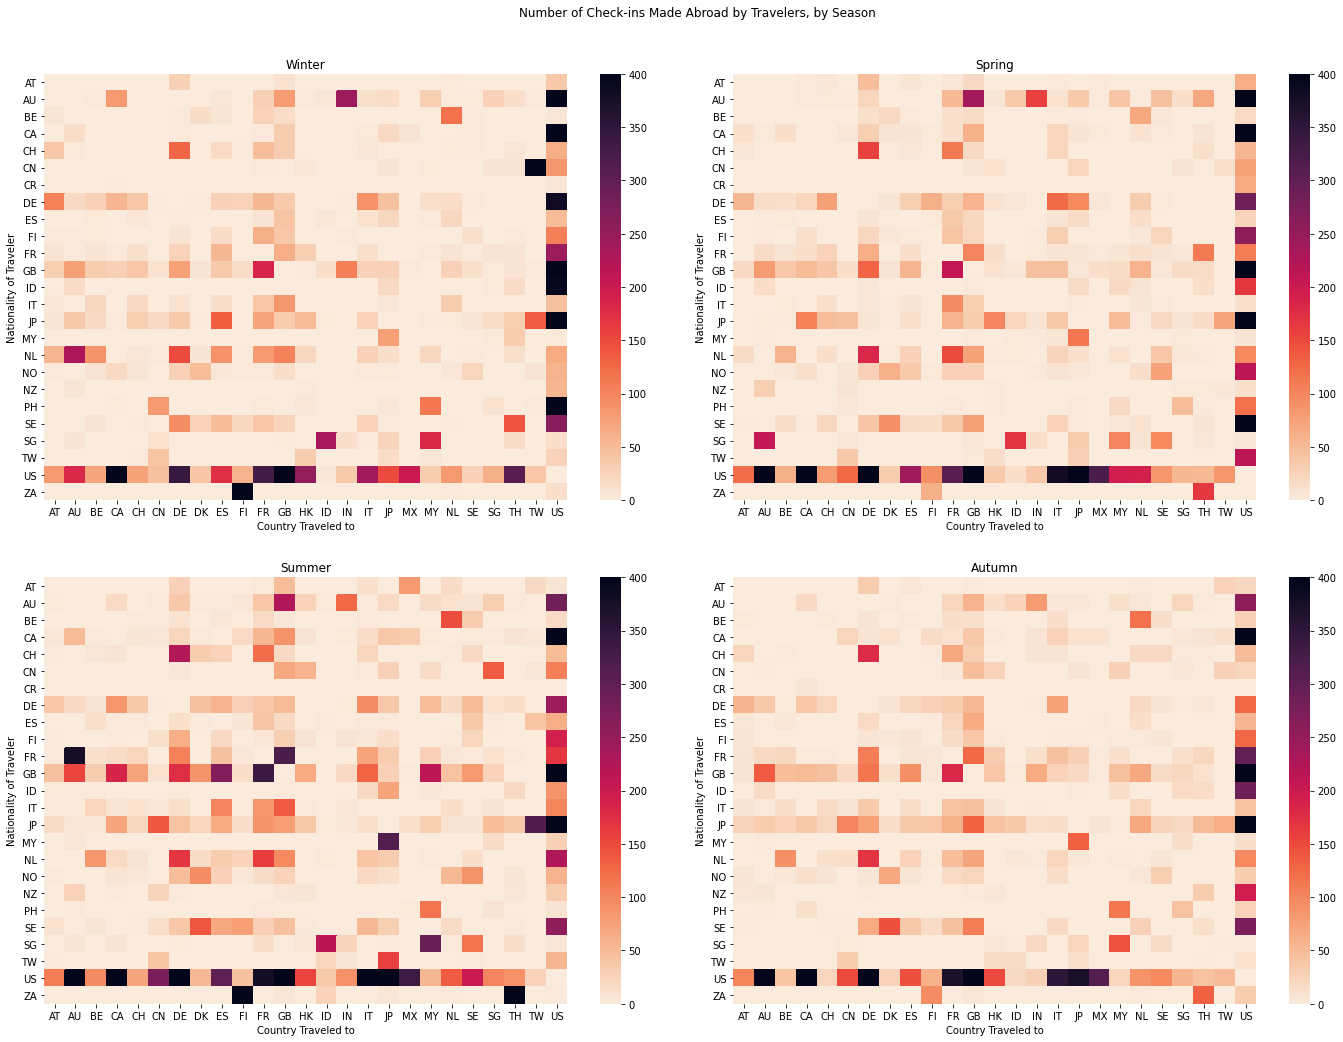

In [9]:
fig, axs = plt.subplots(2, 2, figsize = (20, 15))
axs = axs.ravel()

# Do the same analysis for the seasons
for i,season in enumerate(seasons):
    bk_seasonal_checkins = checkin_brightkite_abroad[checkin_brightkite_abroad['season'] == season]
    bk_heatmap_season = pd.crosstab(bk_seasonal_checkins['user_nationality'],bk_seasonal_checkins['cc'])
    
    sns.heatmap(bk_heatmap_season, cmap="rocket_r", ax=axs[i], vmin=0, vmax=1600/4)
    
    axs[i].title.set_text(season.capitalize())
    axs[i].set_xlabel('Country Traveled to')
    axs[i].set_ylabel('Nationality of Traveler')

plt.suptitle('Number of Check-ins Made Abroad by Travelers, by Season')
fig.tight_layout(pad = 3)
plt.show()

At first glance, there is more travel happening during the summer, as expected. We notice these slight changes:
- Austria gets an increase in visits from Swiss, German, Dutch and British travelers during the winter. This is probably due to the popularity of the skiing industry in the country. 
- A lot of people from China go to Taiwan during the winter,and to Singapore during the summer. 
- Germany gets a high number of visits from neighbouring countries during the fall: this coincides with the Oktoberfest celebrations. 

We noticed that South-African users tend to travel almost exclusively to Finland in winter, and to Thailand in the remaining seasons. A closer data inspection shows that all these check-ins point back to two users (one for each of the destinations). Furthermore, almost all of these check-ins are at the exact same location. We conclude that such unusual patterns are probably generated by a bot.   

### Finding popular tourist locations

In [10]:
checkin_brightkite_abroad = checkin_brightkite[checkin_brightkite['is_abroad']].copy()

In [85]:
checkin_brightkite_abroad_coor = list(checkin_brightkite_abroad.parallel_apply(extract_coordinates, axis = 1))
checkin_brightkite_abroad['city'] = ['{}, {}'.format(gc['city'], gc['country']) for gc in rg_cities.search(checkin_brightkite_abroad_coor)]

tourist_geohashes = checkin_brightkite_abroad.groupby('city')[['latitude', 'longitude', 'user']].aggregate({'latitude': 'mean', 'longitude' : 'mean', 'user': 'count'}).reset_index()
tourist_geohashes = tourist_geohashes[tourist_geohashes['user'] > 100].rename(columns = {'user' : 'checkins'})

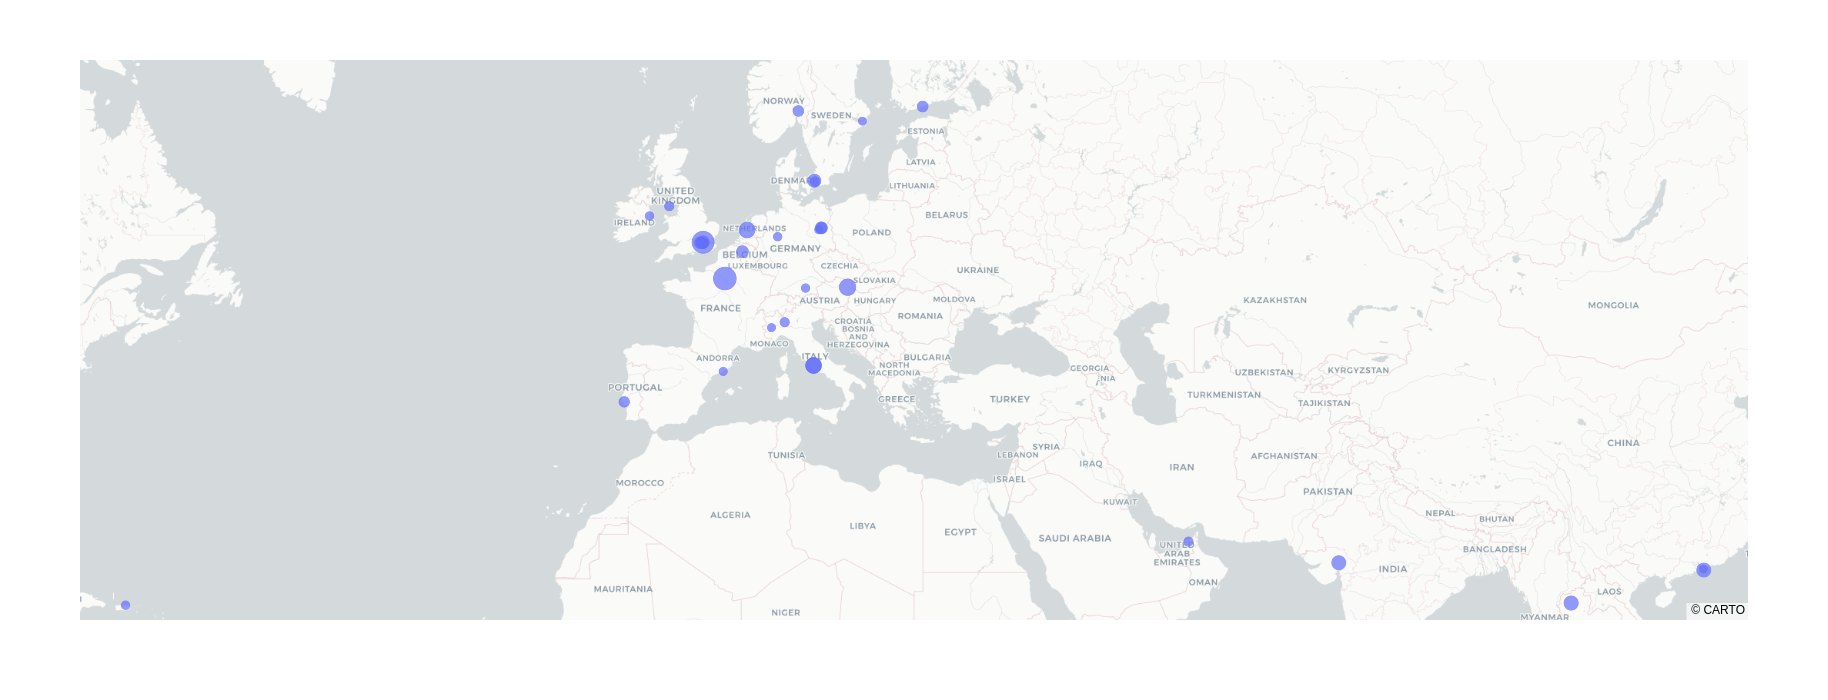

In [50]:
fig = px.scatter_mapbox(tourist_geohashes,lat="latitude", lon="longitude", size="checkins", height=700, hover_name='city')
fig.update_layout(mapbox_style="carto-positron") 
fig.show()

## TODO

- Interactive map with slider for viz throughout time
- Finding popular tourist locations
- Data story idea (and modify abstract accordingly)